In [3]:
!pip install transformers
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 23.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 KB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.2/763.2 KB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 24.1 MB/s eta 0:00:00a 0:00:01


In [4]:
from transformers import logging

import random
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

2022-06-17 07:26:37.566000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-17 07:26:37.566045: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# setting up seed
seed = 123

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

logging.set_verbosity_error()

In [6]:
BATCH_SIZE = 32 # batch size used on the train and validation set
NUM_TRAIN_EPOCHS = 5 # number of iterations for the model training
MAX_SEQ_LENGTH = 128 # used to cut/pad the text into tokens

In [7]:
# Loading the dataset
path = '../../datasets/'
taxonomy = pd.read_csv(path + 'taxonomy.csv')
queries, labels = taxonomy['query'].to_numpy(), taxonomy['label'].to_numpy()

In [8]:
# Encoding the labels to binary values
bin_encoder = LabelEncoder()
taxonomy['label'] = bin_encoder.fit_transform(taxonomy['label'])

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=MAX_SEQ_LENGTH,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']

# initialize two arrays for input tensors
Xids = np.zeros((len(taxonomy), MAX_SEQ_LENGTH))
Xmask = np.zeros((len(taxonomy), MAX_SEQ_LENGTH))

for i, sentence in enumerate(taxonomy['query']):
    Xids[i, :], Xmask[i, :] = tokenize(sentence)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

2022-06-17 07:26:44.119037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 07:26:44.120161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-17 07:26:44.120363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-17 07:26:44.120481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-17 07:26:44.120592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [10]:
label_values = taxonomy['label'].values  # take label column in the dataframe as array
labels = np.zeros((label_values.size, label_values.max()+1))  # initialize empty (all zero) label array
labels[np.arange(label_values.size), label_values] = 1  # add ones in indices where we have a value

In [11]:
import tensorflow as tf

# load arrays into tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# create a mapping function that we use to restructure our dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# using map method to apply map_func to dataset
dataset = dataset.map(map_func)

# shuffle data and batch it
dataset = dataset.shuffle(500).batch(BATCH_SIZE)

In [12]:
# get the length of the batched dataset
DS_LEN = len([0 for batch in dataset])

train_size = int(0.7 * DS_LEN)
val_size = int(0.1 * DS_LEN)
test_size = int(0.2 * DS_LEN)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

del dataset  # delete dataset to free up disk-space

In [13]:
# Helper function for merging new history objects with older ones
def append_history(losses, val_losses, accuracy, val_accuracy, history):
    losses = losses + history.history["loss"]
    val_losses = val_losses + history.history["val_loss"]
    accuracy = accuracy + history.history["binary_accuracy"]
    val_accuracy = val_accuracy + history.history["val_binary_accuracy"]
    return losses, val_losses, accuracy, val_accuracy


# Plotter function
def plot_history(losses, val_losses, accuracies, val_accuracies):
    plt.plot(losses)
    plt.plot(val_losses)
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.plot(accuracies)
    plt.plot(val_accuracies)
    plt.legend(["train_accuracy", "val_accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

In [14]:
from transformers import TFBertModel

def create_model():
    # initialize cased BERT model
    bert = TFBertModel.from_pretrained('bert-base-uncased')

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), name='attention_mask', dtype='int32')

    # we consume the last_hidden_state tensor from bert (discarding pooled_outputs)
    embeddings = bert(input_ids, attention_mask=mask)[0]

    X = tf.keras.layers.LSTM(64)(embeddings)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    y = tf.keras.layers.Dense(2, activation='sigmoid', name='outputs')(X)

    # define input and output layers of our model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    # freeze the BERT layer - otherwise we will be training 100M+ parameters...
    model.layers[2].trainable = False

    model.summary()
    return model

In [15]:
def train_full_model(full_train_dataset, val_dataset, test_dataset):
    model = create_model()
    
    model.compile(
        optimizer="rmsprop", 
        loss="binary_crossentropy",
        metrics=[            
            tf.keras.metrics.BinaryAccuracy(),
            tf.keras.metrics.FalseNegatives(),
            tf.keras.metrics.FalsePositives()
        ],
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, verbose=1)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                "BERT_Full.h5", verbose=1, save_best_only=True)
    history = model.fit(full_train_dataset, validation_data=val_dataset, epochs=NUM_TRAIN_EPOCHS,
        callbacks=[early_stopping, model_checkpoint])
    
    # Plot history
    plot_history(
        history.history["loss"],
        history.history["val_loss"],
        history.history["binary_accuracy"],
        history.history["val_binary_accuracy"],
    )

    # Loading the best checkpoint
    model = tf.keras.models.load_model("BERT_Full.h5", custom_objects={"TFBertModel": TFBertModel})

    print("-" * 100)
    print(
        "Test set evaluation: ",
        model.evaluate(test_dataset, verbose=0, return_dict=True),
    )
    print("-" * 100)

    return model

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

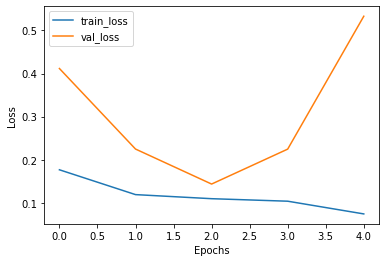

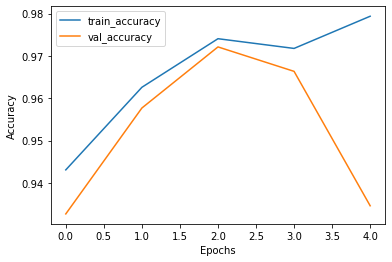

----------------------------------------------------------------------------------------------------
Test set evaluation:  {'loss': 0.041844237595796585, 'binary_accuracy': 0.9904233813285828, 'false_negatives': 9.0, 'false_positives': 10.0}
----------------------------------------------------------------------------------------------------


In [16]:
# Training the model
full_dataset_model = train_full_model(train_dataset, val_dataset, test_dataset)